In [101]:
# hack to import from parent directory
import sys
import os.path
# get the current path
path = os.path.dirname(os.path.abspath(__name__))
# add the directory to the path
sys.path.insert(0, path)

from sac_env_config import env_to_configs
from sac_game_wrapper import Float32Wrapper
# from maybe_wandb import get_wandb
# from replay_memory import ReplayMemory

In [102]:
import wandb as wdb
def get_wandb(get_real = False):
    if get_real:    
        return wdb
    else:
        class FakeWandb:
            @staticmethod
            def init(*args, **kwargs):
                pass
            @staticmethod
            def log(*args, **kwargs):
                pass
            @staticmethod
            def finish(*args, **kwargs):
                pass
        return FakeWandb

from collections import deque, namedtuple
import random
import numpy as np
import torch
import reverb


replayItem = namedtuple('replayItem', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayMemory:
    def __init__(self, capacity) -> None:
        self.memory = deque(maxlen=capacity)

    def append(self, *args) -> None:
        self.memory.append(replayItem(*args))

    def sample(self, batch_size, device) -> list:
        if len(self.memory) < batch_size:
            samples = [random.choice(self.memory) for _ in range(batch_size)]
        else:
            samples = random.sample(self.memory, batch_size)

        reshaped_items = tuple(map(np.stack, zip(*samples)))
        result = tuple(map(lambda x: torch.from_numpy(x).to(device), reshaped_items))

        return result
    
    def __len__(self) -> int:
        return len(self.memory)

class ReverbMemory:
    def __init__(self, capacity) -> None:
        self.table_name = 'priority_table'
        self.server = reverb.Server(tables=[
            reverb.Table(
                name=self.table_name,
                sampler=reverb.selectors.Uniform(),
                remover=reverb.selectors.Fifo(),
                max_size=capacity,
                rate_limiter=reverb.rate_limiters.MinSize(1),
            )
        ])
        self.writer_client = reverb.client.Client(f'localhost:{self.server.port}')
        self.reader_client = reverb.client.Client(f'localhost:{self.server.port}')

    def append(self, *args) -> None:
        self.writer_client.insert(replayItem(*args), priorities={self.table_name: 1.0})

    def sample(self, batch_size, device) -> tuple[np.ndarray,...]:
        samples = self.reader_client.sample(self.table_name, num_samples=batch_size)
        result = [sample[0].data for sample in samples]

        reshaped_items = tuple(map(np.stack, zip(*result)))
        result = tuple(map(lambda x: torch.from_numpy(x).to(device), reshaped_items))

        return result

    def __len__(self) -> int:
        return self.writer_client.server_info()['priority_table'].current_size


In [103]:
import torch
import numpy as np
import gym
from matplotlib import pyplot as plt
import numpy as np

In [104]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
print(f"Using device: {DEVICE}")

Using device: cuda:0


In [105]:
class Critic(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers1, self.layers2 = self._build_network(dims)

    def _build_network(self, dims):
        layers1 = []
        layers2 = []
        for i in range(len(dims)-1):
            layers1.append(torch.nn.Linear(dims[i], dims[i+1]))
            layers2.append(torch.nn.Linear(dims[i], dims[i+1]))
            if i < len(dims) - 2:
                layers1.append(torch.nn.LeakyReLU())
                layers2.append(torch.nn.LeakyReLU())
        return torch.nn.Sequential(*layers1), torch.nn.Sequential(*layers2)
    
    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        return self.layers1(x), self.layers2(x)

In [106]:
class Actor(torch.nn.Module):
    def __init__(self, dims, high=None, low=None):
        super().__init__()
        self.layers = torch.nn.Sequential()
        
        for i in range(len(dims)-2):
            self.layers.append(torch.nn.Linear(dims[i], dims[i+1]))
            if i != len(dims)-2:
                self.layers.append(torch.nn.LeakyReLU())

        self.mu_layer = torch.nn.Linear(dims[-2], dims[-1])
        self.sigma_layer = torch.nn.Linear(dims[-2], dims[-1])
        
        if high is None or low is None:
            self.action_scale = torch.tensor(1.0)
            self.action_bias = torch.tensor(0.0)
        else:
            self.action_scale = torch.tensor((high - low) / 2)
            self.action_bias = torch.tensor((high + low) / 2)
            
    def sample(self, x):
        mus, sigmas = self.forward(x)
        sigmas = torch.exp(sigmas)
        action = torch.distributions.Normal(mus, sigmas).sample()
        action = torch.tanh(action) * self.action_scale + self.action_bias
        return action

    def sample_with_log_prob(self, x):
        mus, sigmas = self.forward(x)
        sigmas = torch.exp(sigmas)
        probs = torch.distributions.Normal(mus, sigmas)
        action = probs.rsample()

        # Adjusting for the tanh squashing function
        log_prob = probs.log_prob(action)
        log_prob -= (2 * (np.log(2) - action - torch.nn.functional.softplus(-2 * action)))
        log_prob = log_prob.sum(1, keepdim=True)

        action = torch.tanh(action) * self.action_scale + self.action_bias

        return action, log_prob
    
    def deterministic_action(self, x):
        mus, sigmas = self.forward(x)
        action = torch.tanh(mus) * self.action_scale + self.action_bias
        return action
           
    def forward(self, x):
        mid = self.layers(x)
        mus = self.mu_layer(mid)
        sigmas = self.sigma_layer(mid)
        sigmas = torch.clamp(sigmas, min=-20, max=2)
        return mus, sigmas

In [107]:
class SAC:
    def __init__(self, env):
        
        input_size = env.observation_space.shape[0]
        output_size = env.action_space.shape[0]
        policy_hidden_dim = [64, 64]
        q_hidden_dim = [64, 64]
        
        self.policy_net_dims = [input_size, *policy_hidden_dim, output_size]
        self.critic_net_dims = [input_size + output_size, *q_hidden_dim, 1]
                
        self.gamma = 0.99
        self.batch_size = 64
        self.steps_to_wait = 512
        self.polyak = 0.995

        self.log_alpha = torch.nn.Parameter(torch.tensor(np.log(0.2)))
        self.target_entropy = -torch.prod(torch.tensor(env.action_space.shape))
        
        self.env = env
        self.replay_buffer = ReplayMemory(100000)
        
        self.policy = Actor(self.policy_net_dims, env.action_space.high, env.action_space.low)
        self.critic = Critic(self.critic_net_dims)
        self.critic_t = Critic(self.critic_net_dims)
        
        self.critic_t.load_state_dict(self.critic.state_dict())
        
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=1e-4)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-4)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=1e-4)
        
        
    def train(self, episodes=300):
        state, info = self.env.reset()
        state = torch.tensor(state)
        r = 0
        scores = []
        losses = []
        for episode in range(episodes):
            state, _ = self.env.reset()
            scores.append([])
            losses
            while True:
                # gather experience
                action = self.policy.sample(torch.from_numpy(state).to(DEVICE))
                next_state, reward, done, trunc, _ = self.env.step(action.numpy(force=True))
                scores[-1].append(reward)
                done = done or trunc
                self.replay_buffer.append(state, action.detach().cpu(), reward, next_state, done)
                
                state = next_state
                
                # sample from buffer
                states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size, device=DEVICE)
                actions = actions.view(-1, 1)
                rewards = rewards.view(-1, 1)
                dones = dones.view(-1, 1)


                # update critic
                next_actions, next_log_prob = self.policy.sample_with_log_prob(next_states)
                q1tv, q2tv = self.critic_t(next_states, next_actions)
                target = rewards + self.gamma * (~dones) * torch.min(q1tv, q2tv) - self.log_alpha.exp() * next_log_prob
                target = target.detach()
                                
                q1v, q2v = self.critic(states, actions)
                q1_loss = torch.nn.functional.mse_loss(q1v, target)
                q2_loss = torch.nn.functional.mse_loss(q2v, target)
                
                critic_loss = q1_loss + q2_loss
                
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                
                
                # update policy
                now_actions, now_log_prob = self.policy.sample_with_log_prob(next_states)                
                q1v, q2v = self.critic(states, now_actions)
                
                policy_loss = torch.mean(self.log_alpha.exp() * now_log_prob - torch.min(q1v, q2v))
                
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                self.policy_optimizer.step()
                
                # update alpha
                alpha_loss = torch.mean(self.log_alpha.exp() * (-self.target_entropy - now_log_prob).detach())
                self.alpha_optimizer.zero_grad()
                alpha_loss.backward()
                self.alpha_optimizer.step()
                

                losses.append([q1_loss.item(), q2_loss.item(), policy_loss.item(), alpha_loss.item(), self.log_alpha.exp().item()])
                
                # update target networks using polyak averaging
                for target_param, param in zip(self.critic_t.parameters(), self.critic.parameters()):
                    target_param.data.copy_(target_param.data * (1.0 - self.polyak) + param.data * self.polyak)
                        

                if done:
                    break
        
                    
            print(f"Episode: {episode+1}, Reward: {sum(scores[-1])}")
        return scores, losses

            

In [108]:
sac = SAC(Float32Wrapper(gym.make('Pendulum-v1')))
wandb_config = {
    "type": "Self-Implemented DQN",
    "buffer_type": "Deque",
    # "enviroment": chosen_env,
    # "num_steps": config.max_steps,
    # "num_episodes": config.num_episodes,
    # "batch_size": config.batch_size,
    "machine": os.uname().nodename,
}

wandb = get_wandb(get_real=False)

wandb.init(
    project="SAC Comparison",
    config=wandb_config,
)
scores, losses = sac.train(100)

Episode: 1, Reward: -1257.1189957857132
Episode: 2, Reward: -1461.5532128214836
Episode: 3, Reward: -1291.3732098937035
Episode: 4, Reward: -1725.8091101646423
Episode: 5, Reward: -1182.2953675985336
Episode: 6, Reward: -1182.4882625639439
Episode: 7, Reward: -1484.6310048103333
Episode: 8, Reward: -1265.7033451795578
Episode: 9, Reward: -1581.0984482765198
Episode: 10, Reward: -1474.3518443256617
Episode: 11, Reward: -1629.1033762693405
Episode: 12, Reward: -1530.761351492256
Episode: 13, Reward: -1546.7841999456286
Episode: 14, Reward: -1710.0106027126312
Episode: 15, Reward: -1650.8319319486618
Episode: 16, Reward: -1683.7092221975327
Episode: 17, Reward: -1655.2691390514374
Episode: 18, Reward: -1785.439302444458
Episode: 19, Reward: -1597.7931979745626
Episode: 20, Reward: -1845.4269495010376
Episode: 21, Reward: -1774.3509488105774
Episode: 22, Reward: -1719.1529717445374
Episode: 23, Reward: -1460.5720477756113
Episode: 24, Reward: -1700.4292590618134
Episode: 25, Reward: -1676.

KeyboardInterrupt: 

In [110]:
score_sums = [sum(score) for score in scores]
plt.plot(score_sums)
# plot running average
window = 5
plt.plot([sum(score_sums[i:i+window])/window for i in range(len(score_sums)-window)])
plt.show()

NameError: name 'scores' is not defined

In [ ]:
trimmed_losses = losses
# trimmed_losses = losses[-5000:]

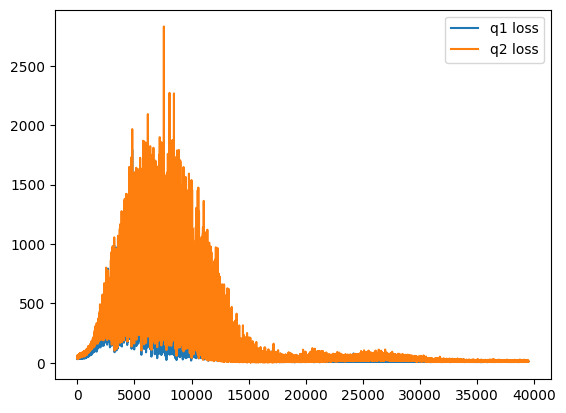

In [ ]:
plt.plot(list([l[0], l[1]] for l in trimmed_losses))
plt.legend(['q1 loss', 'q2 loss'])

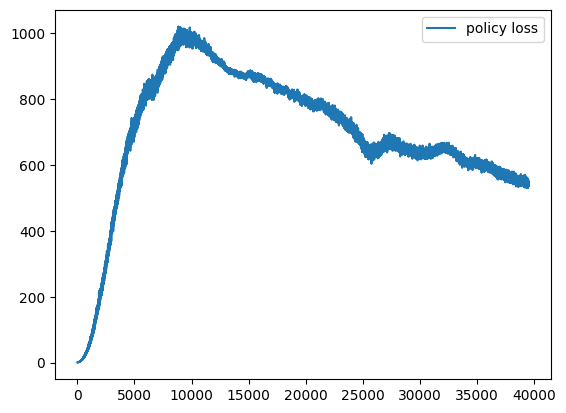

In [ ]:
plt.plot([l[2] for l in trimmed_losses])
plt.legend(['policy loss'])

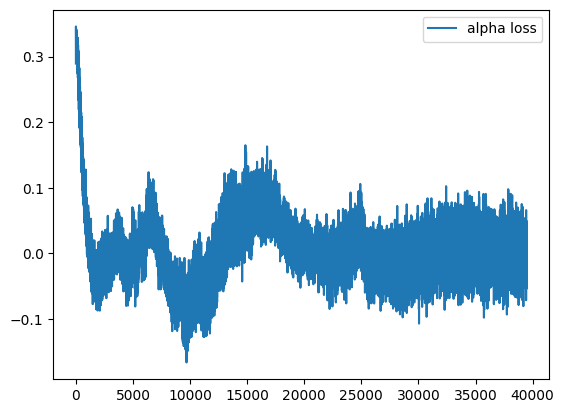

In [ ]:
plt.plot([l[3] for l in trimmed_losses])
plt.legend(['alpha loss'])

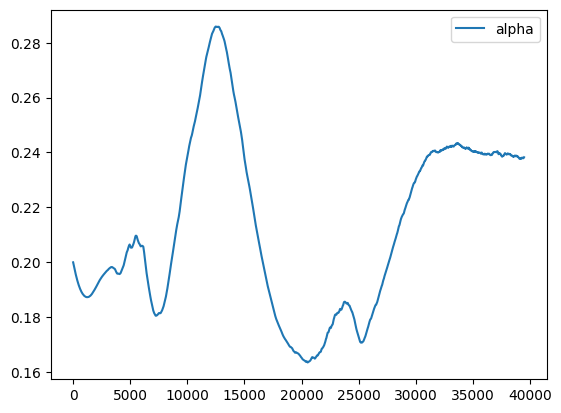

In [ ]:
plt.plot([l[4] for l in trimmed_losses])
plt.legend(['alpha'])

In [ ]:
import cv2

def capture_episode(env, policy):
    frames = []
    state, info = env.reset()
    done = False
    trunc = False
    while not done and not trunc:
        frames.append(env.render())
        action = policy.sample(torch.tensor(state, dtype=torch.float32)).detach().numpy()
        state, _, done, trunc, info = env.step(action)
    env.close()
    return frames

def save_video(frames, filename='sac_pendulum.mp4', fps=30):
    height, width, _ = frames[0].shape
    video = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for frame in frames:
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    video.release()
    
# Usage
env = gym.make('Pendulum-v1', render_mode='rgb_array')
frames = capture_episode(env, sac.policy)
save_video(frames)